In [1]:
import torch as th
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = th.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = th.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

print("Number of training samples:", len(train_dataset))
print("Number of testing samples:", len(test_dataset))

Number of training samples: 60000
Number of testing samples: 10000


In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CAN(nn.Module):
    def __init__(self, num_channels=32):
        super(CAN, self).__init__()
        self.fc1 = nn.Conv2d(1, num_channels, 3, padding=1)
        self.fc2 = nn.Conv2d(num_channels, num_channels, 3, dilation=2, padding=2)
        self.fc3 = nn.Conv2d(num_channels, num_channels, 3, dilation=4, padding=4)
        self.fc4 = nn.Conv2d(num_channels, num_channels, 3, dilation=8, padding=8)
        self.fc5 = nn.Conv2d(num_channels, 10, 3, dilation=1, padding=1)

        self.avgpool = nn.AvgPool2d(28)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = F.leaky_relu(self.fc4(x))
        x = F.leaky_relu(self.fc5(x))
        x = self.avgpool(x)
        x = x.view(-1, 10)

        return x

In [3]:
def train(model, train_loader, optimizer, criterion, epochs, device):
    model.train()
    running_loss = 0.0

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if i % 300 == 299:
                print(f"Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 300:.6f}")
            running_loss = 0.0

    return model

def test(model, test_loader, device):
    correct = 0
    total = 0

    with th.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = th.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %0.2f %%' % (100 * correct / total))

    return 100 * correct / total



Epoch: 1, Batch: 300, Loss: 0.007678
Epoch: 1, Batch: 600, Loss: 0.007661
Epoch: 1, Batch: 900, Loss: 0.007246
Epoch: 2, Batch: 300, Loss: 0.002755
Epoch: 2, Batch: 600, Loss: 0.001344
Epoch: 2, Batch: 900, Loss: 0.001380
Epoch: 3, Batch: 300, Loss: 0.000364
Epoch: 3, Batch: 600, Loss: 0.000607
Epoch: 3, Batch: 900, Loss: 0.000804
Epoch: 4, Batch: 300, Loss: 0.000549
Epoch: 4, Batch: 600, Loss: 0.000173
Epoch: 4, Batch: 900, Loss: 0.000110
Epoch: 5, Batch: 300, Loss: 0.000181
Epoch: 5, Batch: 600, Loss: 0.000419
Epoch: 5, Batch: 900, Loss: 0.000131
Epoch: 6, Batch: 300, Loss: 0.000139
Epoch: 6, Batch: 600, Loss: 0.000424
Epoch: 6, Batch: 900, Loss: 0.000180
Epoch: 7, Batch: 300, Loss: 0.000144
Epoch: 7, Batch: 600, Loss: 0.000380
Epoch: 7, Batch: 900, Loss: 0.000292
Epoch: 8, Batch: 300, Loss: 0.000121
Epoch: 8, Batch: 600, Loss: 0.000152
Epoch: 8, Batch: 900, Loss: 0.000680
Epoch: 9, Batch: 300, Loss: 0.000233
Epoch: 9, Batch: 600, Loss: 0.000347
Epoch: 9, Batch: 900, Loss: 0.000057
E

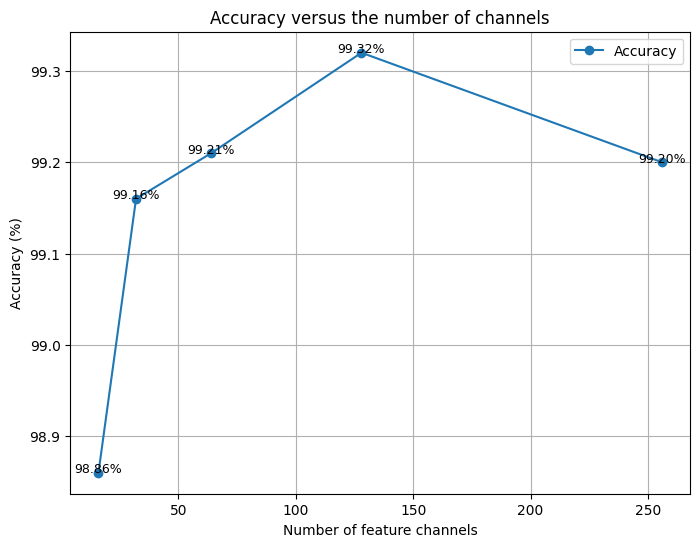

In [4]:
import matplotlib.pyplot as plt

def main():
    device = th.device("cuda" if th.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()
    epochs = 20
    channels = [16, 32, 64, 128, 256]
    accuracy_list = []

    for channel in channels:
        model = CAN(channel).to(device)
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        model = train(model, train_loader, optimizer, criterion, epochs, device)
        accuracy = test(model, test_loader, device)
        accuracy_list.append(accuracy)

    plt.figure(figsize=(8, 6))
    plt.plot(channels, accuracy_list, marker="o", label="Accuracy")
    for i, acc in enumerate(accuracy_list):
        plt.text(channels[i], acc, f"{acc:.2f}%", fontsize=9, ha="center")
    plt.xlabel("Number of feature channels")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy versus the number of channels")
    plt.grid(True)
    plt.legend()
    plt.savefig("CAN_accuracy.png")
    plt.show()

if __name__ == "__main__":
    main()